In [1]:
import sys 
sys.path.insert(0,'/home/mohit/Downloads/code_notebooks/deep_boltzmann')
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import keras
import tensorflow as tf

Using TensorFlow backend.


In [2]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [3]:
rcParams.update({'font.size': 16})

In [4]:
# Switch AUTORELOAD ON. Disable this when in production mode!
%load_ext autoreload
%autoreload 2

In [5]:
from deep_boltzmann.models import ParticleDimer
from deep_boltzmann.networks.invertible import invnet, EnergyInvNet, create_RealNVPNet
from deep_boltzmann.sampling import GaussianPriorMCMC
from deep_boltzmann.sampling.latent_sampling import BiasedModel
from deep_boltzmann.sampling.permutation import HungarianMapper
from deep_boltzmann.util import load_obj, save_obj

In [6]:
from deep_boltzmann.sampling.analysis import free_energy_bootstrap, mean_finite, std_finite

In [7]:
# reweighting
def test_sample_rew(network, rcfunc, rcmin, rcmax, temperature=1.0, nsample=100000):
    sample_z, sample_x, energy_z, energy_x, log_w = network.sample(temperature=1.0, nsample=nsample)
    bin_means, Es = free_energy_bootstrap(rcfunc(sample_x), rcmin, rcmax, 100, sample=100, weights=np.exp(log_w))
    fig = plt.figure(figsize=(5, 4))
    # model.plot_dimer_energy()
    plt.ylim(-10, 20)
    Emean = mean_finite(Es, axis=0)-7
    Estd = std_finite(Es, axis=0)
    plt.errorbar(bin_means, Emean, 2*Estd)
    # variance
    var = mean_finite(std_finite(Es, axis=0) ** 2)
    print('Estimator Standard Error: ', np.sqrt(var))
    return fig, bin_means, Emean, Estd

In [8]:
def latent_interpolation(bg, x1, x2, nstep=1000, through_origin=False):
    lambdas = np.array([np.linspace(0, 1, num=nstep)]).T
    x1 = np.array([x1])
    x2 = np.array([x2])
    z1 = bg.transform_xz(x1)
    z2 = bg.transform_xz(x2)
    if through_origin:
        zpath1 = z1 * (1-lambdas[::2])
        zpath2 = z2 * (lambdas[::2]) 
        zpath = np.vstack([zpath1, zpath2])
    else:
        zpath = z1 + lambdas*(z2-z1)
    xpath = bg.transform_zx(zpath)
    return xpath

In [9]:
def low_energy_fraction(energies, Emax):
    low_energy_count = [np.count_nonzero(E<Emax) for E in energies]
    sizes = [E.size for E in energies]
    low_energy_fraction = np.array(low_energy_count) / sizes
    return low_energy_fraction

In [10]:
def plot_convergence(hist_ML, hist_KL, enerx_cut, enerz_cut, MLcol=1, KLcol=2):
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5, 10))
    niter1 = len(hist_ML[0])
    niter2 = hist_KL[1].shape[0]
    niter = niter1 + niter2
    # ML loss
    losses_ML = np.concatenate([hist_ML[0], hist_KL[1][:, MLcol]])
    xticks = np.arange(niter1 + niter2) + 1
    axes[0].plot(xticks, losses_ML, color='black')
    axes[0].set_xlim(0, niter + 1)
    axes[0].set_ylabel('ML loss')
    axes[0].axvline(x=200, color='red', linestyle='--', linewidth=3)
    # KL loss
    losses_KL = hist_KL[1][:, KLcol]
    xticks = np.arange(niter1, niter1 + niter2) + 1
    axes[1].plot(xticks, losses_KL, color='black')
    axes[1].set_xlim(0, niter + 1)
    axes[1].set_ylabel('KL loss')
    axes[1].axvline(x=200, color='red', linestyle='--', linewidth=3)
    # low energy fractions
    enerx = hist_ML[2] + hist_KL[3]
    enerz = hist_ML[3] + hist_KL[4]
    lef_x = low_energy_fraction(enerx, enerx_cut)
    lef_z = low_energy_fraction(enerz, enerz_cut)
    axes[2].plot(lef_x, color='black', label='x')
    axes[2].plot(lef_z, color='blue', label='z')
    axes[2].set_xlim(0, niter + 1)
    axes[2].set_ylim(0, 1.05)
    axes[2].axvline(x=200, color='red', linestyle='--', linewidth=3)
    axes[2].set_ylabel('Training iterations')
    axes[2].set_ylabel('Low energy fraction')
    axes[2].legend()
    return fig, axes

In [ ]:
paper_dir = '/Users/noe/data/papers/NoeEtAl_BoltzmannGeneratorsRev/'

Particle model
---
Run notebook "Particles_Simulation_Data" to generate data

In [11]:
# load trajectory data
trajdict = np.load('output.npz')
import ast
#params = ast.literal_eval(str(trajdict['params']))
traj_closed_train = trajdict['traj_closed_train_hungarian']
traj_open_train = trajdict['traj_open_train_hungarian']
traj_closed_test = trajdict['traj_closed_test_hungarian']
traj_open_test = trajdict['traj_open_test_hungarian']
x = np.vstack([traj_closed_train, traj_open_train])
xval = np.vstack([traj_closed_test, traj_open_test])

In [12]:
# create model
#params['grid_k'] = 0.0
model = ParticleDimer()

Text(0, 0.5, 'Energy / $kT_0$')

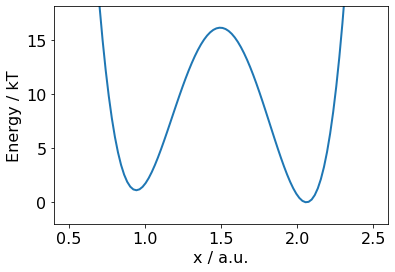

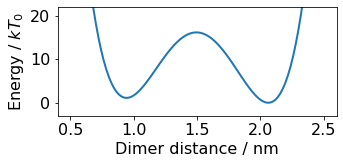

In [13]:
xx, xE = model.plot_dimer_energy();
plt.figure(figsize=(5, 2))
plt.plot(xx, xE, linewidth=2)
plt.ylim(-3, 22)
plt.xlabel('Dimer distance / nm')
plt.ylabel('Energy / $kT_0$')
#plt.savefig(paper_dir + 'figs/particles/particle_dimer_potential.pdf', bbox_inches='tight')

In [14]:
W = np.exp(-xE)
-np.log(np.sum(W[xx < 1.5]) / np.sum(W[xx >= 1.5]))

1.1036920414270517

In [15]:
# hyperparameters
hyperparams = {'layer_types' : 'RRRRRRRR',
               'nl_layers' : 3,
               'nl_hidden' : 200,
               'nl_activation' : 'tanh',
               'zstd' : 1.0,
               'reg_Jxz' : 0.0,
               'temperature' : [0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 3.0, 4.0],
               'weight_ML' : 0.1,
               'weight_W2' : 0.0,
               'weight_RC' : 10.0,
               }

Umbrella sampling reference
-------

In [ ]:
from deep_boltzmann.sampling.umbrella_sampling import UmbrellaSampling
from deep_boltzmann.sampling.metropolis import MetropolisGauss

In [ ]:
## Either run Umbrella Sampling here....
#sampler = MetropolisGauss(model, model.init_positions(1.0), noise=0.02, stride=10)
#sampler.run(nsteps=10000)
#us = UmbrellaSampling(model, sampler, model.dimer_distance, sampler.traj[-1], 30, 250, 0.7, 2.3, forward_backward=True)
#us.run(nsteps=20000, verbose=True)

In [ ]:
## ... or load saved Umbrella Sampling data.
npzfile = np.load('./particles/US_data.npz')
colors = ['black', 'purple', 'blue', 'orange', 'red']
x = npzfile['umbrella_positions']
temperatures_US = npzfile['temperatures']
dF_closed_open_US = []
for i, dF in enumerate(npzfile['umbrella_free_energies']):
    icolor = i // 3
    plt.plot(x, dF, color=colors[icolor])
    W = np.exp(-dF)
    dF_at_kT0 = -np.log(np.sum(W[x < 1.5]) / np.sum(W[x >= 1.5]))
    dF_closed_open_US.append(dF_at_kT0)
    print(temperatures_US[i], dF_at_kT0)    

In [ ]:
# Estimate free energy profile and errors at kT=1 
umbrella_positions = npzfile['umbrella_positions']
# split in two halves because we ran forward and backward
umbrella_positions = umbrella_positions[:umbrella_positions.size//2]
umbrella_free_energies = [npzfile['umbrella_free_energies'][i][:umbrella_positions.size] for i in range(9, 12)] \
                       + [npzfile['umbrella_free_energies'][i][umbrella_positions.size:][::-1] for i in range(9, 12)] 
# align values
umbrella_free_energies = [F-F.mean() for F in umbrella_free_energies]

Boltzmann Generator
-------

In [16]:
batchsize_ML =  500
batchsize_KL = 1000
noise_intensity = 0.0

In [17]:
X0 = np.vstack([traj_closed_train, traj_open_train])

In [18]:
Nnoise = xval.shape[0]
X0noise = X0[np.random.choice(X0.shape[0], Nnoise)] + noise_intensity * np.random.randn(Nnoise, X0.shape[1])
X0noise = X0noise.astype(np.float32)

In [19]:
#X0 = np.vstack([traj_closed_train[::100], traj_open_train[::100]])

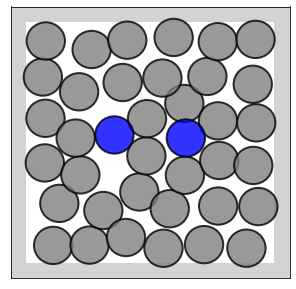

In [20]:
model.draw_config(X0noise[1001], dimercolor='blue', alpha=0.8);

In [21]:
bg = invnet(model.dim, 'RRRRRRRR', energy_model=model, nl_layers=4, nl_hidden=200, #100
            nl_activation='relu', nl_activation_scale='tanh', whiten=X0noise)

W<RRRRRRRR>
W 76 0 0
< 76 0 0
R 38 38 0

R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
> 38 38 0




In [22]:
hist_bg_ML = bg.train_ML(X0noise, xval=xval, epochs=20, lr=0.001, batch_size=batchsize_ML, 

                         std=1.0, verbose=1, return_test_energies=True)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 0/20 loss -82.4674 -7.5123 
Epoch 1/20 loss -99.9464 -9.7022 
Epoch 2/20 loss -100.4211 -37.4576 
Epoch 3/20 loss -102.9522 -50.5814 
Epoch 4/20 loss -105.8784 -51.2939 
Epoch 5/20 loss -107.8894 -49.7231 
Epoch 6/20 loss -110.0865 -42.4944 
Epoch 7/20 loss -110.9072 -36.8787 
Epoch 8/20 loss -112.6052 -33.3896 
Epoch 9/20 loss -111.6352 -31.5377 
Epoch 10/20 loss -112.5767 -31.9561 
Epoch 11/20 loss -113.4821 -25.7681 
Epoch 12/20 loss -113.9088 -25.9044 
Epoch 13/20 loss -114.9196 -23.8076 
Epoch 14/20 loss -115.7217 -28.7403 
Epoch 15/20 loss -116.8747 -25.9832 
Epoch 16/20 loss -117.0840 -22.7150 
Epoch 17/20 loss -118.1900 -21.5796 
Epoch 18/20 loss -119.1534 -25.2048 
Epoch 19/20 loss -118.7354 -20.0252 


In [ ]:
bg.save('temp.pkl')

In [ ]:
anotherModel = invnet(model.dim, 'RRRRRRRR', energy_model=model, nl_layers=4, nl_hidden=200, #100
            nl_activation='relu', nl_activation_scale='tanh', whiten=X0noise)
anotherModel = anotherModel.load('temp.pkl',ParticleDimer())

In [ ]:
print(anotherModel.transform_xz(np.array(traj_closed_train[100])))

In [23]:
temp = bg.transform_xz(np.array([traj_closed_train[100]]) )

In [24]:
print(temp)

[[-1.9136439e-01 -3.6295795e-01  1.8929347e+00 -1.4372662e+00
   2.7687925e-01  1.7916262e-03  4.6686423e-01 -3.2669994e-01
  -5.2496338e-01 -2.5015134e-01 -2.8035492e-02  1.4898741e-01
  -9.0807700e-01  5.8850288e-01  2.7847543e-01 -6.3165259e-03
  -1.1091335e+00 -4.1420981e-01  4.4259635e-01  1.1057134e+00
  -2.2017452e-01  8.1724918e-01 -5.0585765e-01  4.3263382e-01
  -7.7619261e-01  1.7215818e-01  4.8601732e-02  4.9729952e-01
   2.7362162e-01  1.6791856e+00 -1.6750438e+00 -1.0113072e+00
  -5.2381718e-01 -1.0840417e+00 -1.2208850e+00  6.0217315e-01
   3.0833071e-01 -5.2147818e-01  2.5104113e+00 -1.5491956e-01
   5.9782779e-01 -1.8786120e+00  1.1599196e-01  1.2679806e+00
   1.4910948e+00 -5.0013375e-01  1.1120783e+00  7.4351251e-02
  -1.5049066e-01  1.4079745e+00 -2.0047607e+00 -4.9618670e-01
   2.3945968e+00 -8.4831417e-01  1.8398296e+00 -2.1329029e+00
   2.6318485e-01  2.1053953e+00 -5.9011269e-01 -9.4296098e-02
  -2.3220289e+00  7.7804273e-01  9.2890543e-01  4.4993427e-01
   3.860

In [ ]:
plt.plot(hist_bg_ML[0])
plt.plot(hist_bg_ML[1])
#plt.ylim(0, 100)

In [ ]:
_, sample_x, _, energies_x, _ = bg.sample(nsample=20000)
sample_d = model.dimer_distance(sample_x)
plt.hist(sample_d[sample_d < 3], 100, log=True)
plt.xlim(0, 3)

Regular training
-----

In [25]:
temperature=1.0

In [26]:
# initial training
Eschedule = [[20,  0.00001, 1e6, 1e3,  0.0, 10.0],
             [10,  0.0001, 1e6,  300,  0.0, 10.0],
             [10,  0.0001, 1e5,  100,  0.0, 10.0],
             [10,  0.0001, 5e4,   50,  0.0, 10.0],
             [10,  0.0001, 5e4,   20,  0.0, 10.0],
             [20,  0.0001, 5e4,    5,  0.0, 10.0]]

In [27]:
hists_bg_KL = []
for i, s in enumerate(Eschedule):
    print(s)#'high_energy =', s[0], 'weight_ML =', s[1], 'epochs =', s[2])
    sys.stdout.flush()
    hist_bg_KL = bg.train_flexible(X0noise, xval=xval, epochs=s[0], lr=s[1], batch_size=batchsize_KL,
                                   verbose=1, high_energy=s[2], max_energy=1e10,
                                   weight_ML=s[3], weight_KL=1.0, temperature=temperature, weight_MC=0.0, weight_W2=s[4],
                                   weight_RCEnt=s[5], rc_func=model.dimer_distance_tf, rc_min=0.5, rc_max=2.5,
                                   std=1.0, reg_Jxz=0.0, return_test_energies=True)
    hists_bg_KL.append(hist_bg_KL)

[20, 1e-05, 1000000.0, 1000.0, 0.0, 10.0]
Epoch 0/20 loss 58175.4180 144119.7031 index_layer_3_loss -119.7678 -20.1678 lambda_51_loss 177667.0312 164009.2812 lambda_51_loss 27.6190 27.8267 
Epoch 1/20 loss 60706.8477 148692.4375 index_layer_3_loss -119.6655 -21.4350 lambda_51_loss 180094.1719 169852.3906 lambda_51_loss 27.8191 27.5058 
Epoch 2/20 loss 35107.9688 136432.2031 index_layer_3_loss -119.9962 -21.4298 lambda_51_loss 154824.7344 157586.0000 lambda_51_loss 27.9429 27.5982 
Epoch 3/20 loss 60887.4102 161308.1094 index_layer_3_loss -119.4926 -21.9765 lambda_51_loss 180099.2656 183005.3906 lambda_51_loss 28.0708 27.9232 
Epoch 4/20 loss 49786.4609 135663.0781 index_layer_3_loss -120.1215 -22.0761 lambda_51_loss 169632.2812 157459.5000 lambda_51_loss 27.5710 27.9701 
Epoch 5/20 loss 27403.2441 134694.4219 index_layer_3_loss -119.3244 -17.1967 lambda_51_loss 146449.9219 151615.4688 lambda_51_loss 27.7713 27.5609 
Epoch 6/20 loss 41117.4805 158054.8125 index_layer_3_loss -120.1041 -1

Epoch 6/10 loss -1464.0081 799.4935 index_layer_3_loss -109.7688 0.4608 lambda_51_loss 370.1990 439.1989 lambda_51_loss 36.1170 35.1078 
Epoch 7/10 loss -1411.5057 816.3973 index_layer_3_loss -110.5192 -0.5784 lambda_51_loss 427.4542 477.1869 lambda_51_loss 37.1424 35.0779 
Epoch 8/10 loss -1481.2102 772.1036 index_layer_3_loss -110.4420 -0.6782 lambda_51_loss 364.2728 424.4203 lambda_51_loss 36.3356 36.1247 
Epoch 9/10 loss -1416.6802 845.3282 index_layer_3_loss -110.2968 3.8827 lambda_51_loss 431.1597 406.0526 lambda_51_loss 35.8095 36.1622 
[20, 0.0001, 50000.0, 5, 0.0, 10.0]
Epoch 0/20 loss 184.6994 776.9471 index_layer_3_loss -109.5014 1.2984 lambda_51_loss 380.5737 399.8875 lambda_51_loss 35.1633 37.0568 
Epoch 1/20 loss 178.7809 749.8170 index_layer_3_loss -109.4541 4.1598 lambda_51_loss 370.2903 360.7564 lambda_51_loss 35.5761 36.8262 
Epoch 2/20 loss 160.1628 756.4822 index_layer_3_loss -109.5059 4.9627 lambda_51_loss 339.8303 382.0163 lambda_51_loss 36.7862 34.9652 
Epoch 3/2

In [28]:
bg.save('temp.pkl')

In [29]:
anotherModel = invnet(model.dim, 'RRRRRRRR', energy_model=model, nl_layers=4, nl_hidden=200, #100
            nl_activation='relu', nl_activation_scale='tanh', whiten=X0noise)
anotherModel = anotherModel.load('temp.pkl',ParticleDimer())

W<RRRRRRRR>
W 76 0 0
< 76 0 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
> 38 38 0


In [32]:
print(anotherModel.transform_xz(np.array(traj_closed_train[100])))


[[ 0.7790488  -1.3591068   1.655799   -0.40573907  0.3060337   1.1430752
   1.7911785   0.04392639  0.09652224 -0.50464374  0.19326428 -0.8176754
  -0.07836138  0.4919043   0.38416487  0.7287319  -1.597898   -0.23729922
   0.08269466  1.2897888  -0.8365321   0.43377507 -1.0636588   0.86989963
  -1.2108635   0.8200016  -0.19022602  0.8788456   0.69238824  2.4186203
  -1.6040635  -1.4203387  -1.1950686  -0.76688117 -1.8120315  -0.0245631
  -0.01708126 -0.53406847  2.4908009   0.07432495  0.54746497 -2.044306
   0.09633934  0.3655213   1.477061   -0.26735663  0.94472474 -0.01530582
  -0.8485823   1.5948198  -2.0162346   0.28656644  2.0371249   0.20915644
   1.8650852  -2.6227934   0.18871173  1.3419803  -0.9031436   0.30066228
  -2.2032633   0.3172659   1.4275602  -0.06255475  0.22241658  0.35159236
   0.80505496  1.8448981  -1.4323196  -3.6096961  -0.46368212 -2.0166883
  -0.5156255  -0.79101515 -1.8035215   0.05649963]]
(200002, 76)


In [ ]:
xeners = []
zeners = []
for h in hists_bg_KL:
    xeners += h[3]
    zeners += h[4]
hist_bg_KL_combined = [hists_bg_KL[0][0], 
                       np.vstack([h[1] for h in hists_bg_KL]),
                       np.vstack([h[2] for h in hists_bg_KL]),
                       xeners, zeners]

In [ ]:
def plot_convergence(hist_ML, hist_KL, enerx_cut, enerz_cut, MLcol=1, KLcol=2):
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5, 10))
    niter1 = len(hist_ML[0])
    niter2 = hist_KL[1].shape[0]
    niter = niter1 + niter2
    # ML loss
    losses_ML = np.concatenate([hist_ML[0], hist_KL[1][:, MLcol]])
    xticks = np.arange(niter1 + niter2) + 1
    axes[0].plot(xticks, losses_ML, color='black')
    axes[0].set_xlim(0, niter + 1)
    axes[0].set_ylabel('ML loss')
    axes[0].axvline(x=200, color='red', linestyle='--', linewidth=3)
    # KL loss
    losses_KL = hist_KL[1][:, KLcol]
    xticks = np.arange(niter1, niter1 + niter2) + 1
    axes[1].plot(xticks, losses_KL, color='black')
    axes[1].set_xlim(0, niter + 1)
    axes[1].set_ylabel('KL loss')
    axes[1].axvline(x=200, color='red', linestyle='--', linewidth=3)
    # low energy fractions
    enerx = hist_ML[2] + hist_KL[3]
    enerz = hist_ML[3] + hist_KL[4]
    lef_x = low_energy_fraction(enerx, enerx_cut)
    lef_z = low_energy_fraction(enerz, enerz_cut)
    axes[2].plot(lef_x, color='black', label='x')
    axes[2].plot(lef_z, color='blue', label='z')
    axes[2].set_xlim(0, niter + 1)
    axes[2].set_ylim(0, 1.05)
    axes[2].axvline(x=200, color='red', linestyle='--', linewidth=3)
    axes[2].set_ylabel('Training iterations')
    axes[2].set_ylabel('Low energy fraction')
    axes[2].legend()
    return fig, axes

In [ ]:
def energy_cut_z(ndim, nstd=3):
    z = np.random.randn(10000, ndim)
    zener = 0.5 * np.sum(z**2, axis=1)
    #return zener
    std = np.sqrt(np.mean((zener - zener.mean())**2))
    return zener.mean() + nstd*std

In [ ]:
zener = energy_cut_z(model.dim, nstd=3)
#plt.hist(zener, 100);

In [ ]:
xcut = 80
zcut = energy_cut_z(model.dim, nstd=3)
print('zcut = ', zcut)
#hist_bg_KL_arr = np.vstack([hist_bg_KL[1] for hist_bg_KL in hists_bg_KL])
fig, axes = plot_convergence(hist_bg_ML, hist_bg_KL_combined, xcut, zcut, MLcol=1, KLcol=2);
axes[1].semilogy()
#plt.savefig(paper_dir + 'figs/particles/training_convergence.pdf', bbox_inches='tight', transparent=True)

In [ ]:
_, sample_x, _, energies_x, _ = bg.sample(nsample=20000)
sample_d = model.dimer_distance(sample_x)
plt.hist(sample_d[sample_d < 3], 100, log=True)
plt.xlim(0, 3)

In [ ]:
plt.hist(energies_x[np.bitwise_and(energies_x<100, sample_d<1.5)], 100, color='yellow', density=True);
plt.hist(energies_x[np.bitwise_and(energies_x<100, sample_d>1.5)], 100, color='green', density=True);
plt.hist(model.energy(traj_open_train), 100, color='blue', alpha=0.5, density=True);
plt.hist(model.energy(traj_closed_train), 100, color='red', alpha=0.5, density=True);

In [ ]:
model.draw_config(sample_x[1], dimercolor='blue', alpha=0.8);

In [ ]:
# show minimum energy path
Emin = 1e9
bestpath = None
for i in range(90):
    for j in range(90):
        path = latent_interpolation(bg, traj_closed_train[i*100], traj_open_train[j*100], nstep=9)
        E = model.energy(path).max()
        if E < Emin:
            Emin = E
            bestpath = path

In [ ]:
# Compressed version for paper
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(6.5, 10))
model.draw_config(bestpath[0], axis=axes[0, 0], dimercolor='blue', alpha=0.8);
model.draw_config(bestpath[2], axis=axes[1, 0], dimercolor='blue', alpha=0.8);
model.draw_config(bestpath[3], axis=axes[2, 0], dimercolor='orange', alpha=0.8);
model.draw_config(bestpath[4], axis=axes[2, 1], dimercolor='orange', alpha=0.8);
model.draw_config(bestpath[5], axis=axes[1, 1], dimercolor='red', alpha=0.8);
model.draw_config(bestpath[7], axis=axes[0, 1], dimercolor='red', alpha=0.8);
plt.subplots_adjust(wspace=0.03, hspace=0.03)
plt.savefig('interpolate.pdf', bbox_inches='tight')

In [ ]:
bg.save('ParticleModel.pkl')